Osnabrück University - Computer Vision (Winter Term 2020/21) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 04: Segmentation and Color

## Introduction


This week's sheet should be solved and handed in before the end of **Saturday, November 28, 2020**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [1]:
# YOUR CODE HERE

## Assignment 1: Histogram-based segmentation [5 Points]

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

The histogram-based segmentation is a binary segmentation based on the gray values of an image. The main goal is to separate an image into fore- and background. 

This segementation doesn't need much computation time. The original gray values are simply mapped to their corresponding binary value using the previously defined threshold.

The biggest problem is to define a well suited threshold for the specific image. This must be done manually using the histogram or automatically by a suitable function.

### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scikit-image and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

threshold_mean: Returns threshold value based on the mean of grayscale values.

threshold_minimum: Returns threshold value based on minimum method. The histogram of the input image is computed and smoothed until there are only two maxima. Then the minimum in between is the threshold value.

threshold_otsu: Returns threshold value based on Otsu’s method.

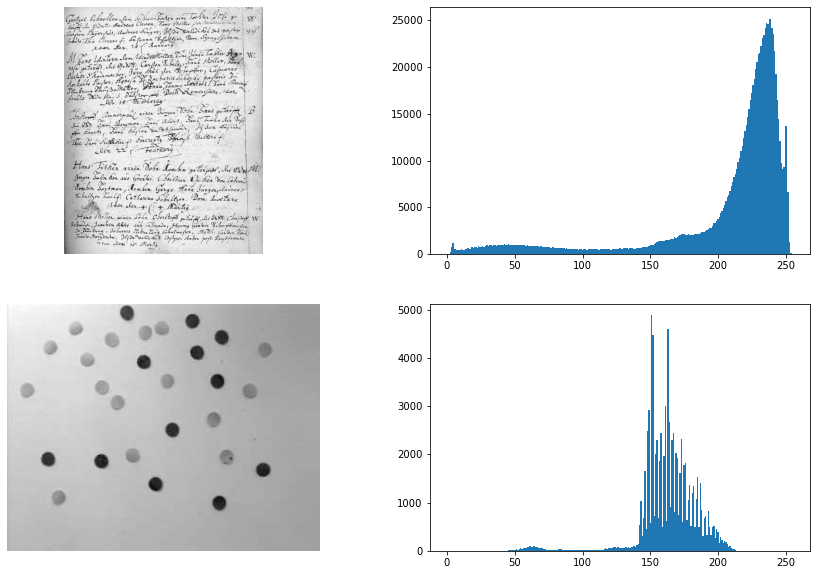

In [3]:
# Run this cell to get an impression of how the histograms look

%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread

img1 = imread('images/schrift.png')
img2 = imread('images/pebbles.jpg') 

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.show()

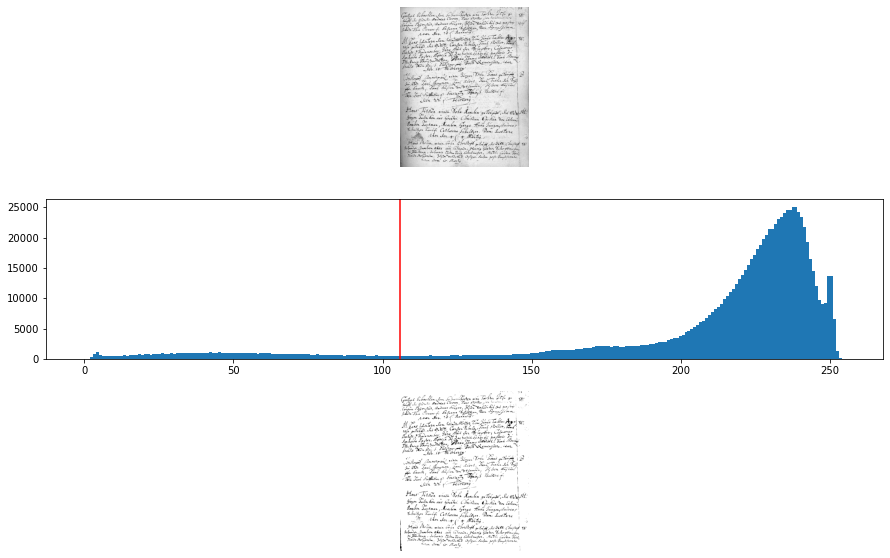

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imreadz
from skimage import filters

img = imread('images/schrift.png') # 'pebbles.jpg' or 'schrift.png'

# YOUR CODE HERE
#thresh = filters.threshold_otsu(img)     #Returns upper threshold value. All pixels with an intensity higher than this value are assumed to be foreground.
#thresh = filters.threshold_mean(img)
thresh = filters.threshold_minimum(img)
segments = img > thresh                  #<=, for white handwriting

plt.figure(figsize=(15, 10))
plt.gray()
plt.subplot(3,1,1); plt.axis('off'); plt.imshow(img)
plt.subplot(3,1,2); plt.hist(img.flatten(), 256, (0,255))
plt.axvline(thresh, color='r')
plt.subplot(3,1,3); plt.axis('off'); plt.imshow(segments)
plt.show()

### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-07 slide 13), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`. You may use filter functions from scikit-image for this exercise.

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

img = imread('images/schrift.png').astype(float)/255
#img = imread('images/pebbles.png').astype(float)/255

# YOUR CODE HERE
thresh = filters.threshold_otsu(img)
background_img = img <= thresh                   #background image = pixels with an intensity lower than the threshold.

shading_function = (1/background_img.astype(float))
corrected_img = img * shading_function
normalized_corrected_img = corrected_img * thresh    #inverts the 1/background_img call from before. -> Normalization back to original values!

new_thresh = filters.threshold_otsu(normalized_corrected_img.astype(int))
resulting_img_after_corrrection = new_thresh > new_thresh

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.show()

<ipython-input-6-1ff06b1711a5>:13: RuntimeWarning: divide by zero encountered in true_divide
  shading_function = (1/background_img.astype(float))


MemoryError: Unable to allocate 16.0 GiB for an array with shape (2147483649,) and data type int64

## Assignment 2: Pyramid representation [5 Points]

**a)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

The Gaussian pyramid scales the input image by several reduce operations. Thus the original image gets smaller and smaller with each repitition. If one batches the results of each repetition, it looks like a pyramid, which is the reason for its name. 

In the reduce operation each pixel of the upper pyramid layer replaces 4 pixels of the lower layer. But the basis of the calculation must not only be these 4 pixels (depends on the algorithm).

Low pass filtering removes high frequencies and lets low frequencies pass (as the name suggests). This is necessary here to avoid artifacts that are caused by a violation of the sampling theorem. That occurs due to... 

<ipython-input-25-027a83498e27>:21: RuntimeWarning: overflow encountered in ubyte_scalars
  first_row_values = np.float64(previous_pyramid_layer[(row*2)-1][(coloumn*2)-1] * previous_pyramid_layer[(row*2)-1][(coloumn*2)])
<ipython-input-25-027a83498e27>:22: RuntimeWarning: overflow encountered in ubyte_scalars
  second_row_values = np.float64(previous_pyramid_layer[(row*2)][(coloumn*2)-1] * previous_pyramid_layer[(row*2)][(coloumn*2)])


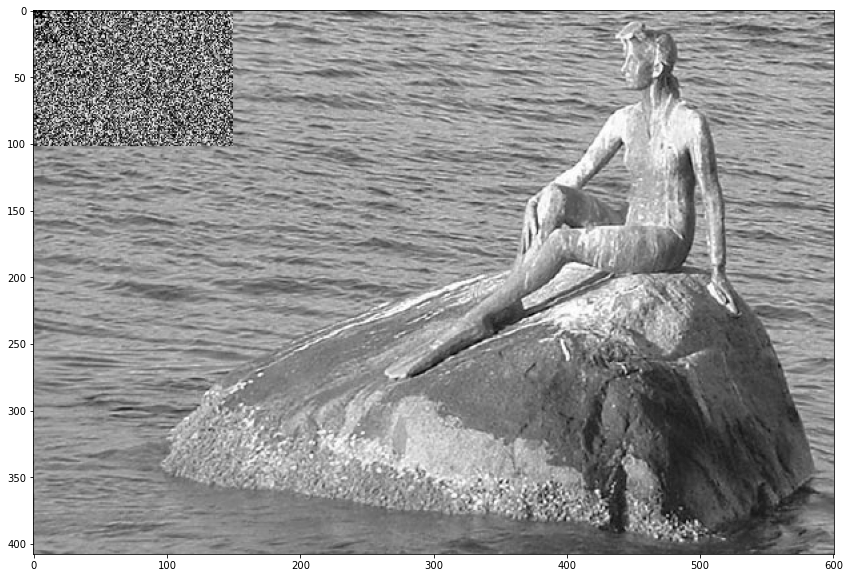

In [25]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread

img = imread('images/mermaid.png')

pyramid_image = img.copy() # change this!

# YOUR CODE HERE
previous_pyramid_layer = pyramid_image
for i in range(5):
    reduced_row_shape = int(previous_pyramid_layer.shape[0] / 4)
    reduced_coloumn_shape = int(previous_pyramid_layer.shape[1] / 4)
    current_pyramid_layer = np.zeros((reduced_row_shape, reduced_coloumn_shape))

    for row in range(current_pyramid_layer.shape[0]):
        for coloumn in range(current_pyramid_layer.shape[1]):
            #4 pixels are merged to 1
            first_row_values = np.float64(previous_pyramid_layer[(row*2)-1][(coloumn*2)-1] * previous_pyramid_layer[(row*2)-1][(coloumn*2)])
            second_row_values = np.float64(previous_pyramid_layer[(row*2)][(coloumn*2)-1] * previous_pyramid_layer[(row*2)][(coloumn*2)])
            current_pyramid_layer[row][coloumn] = np.int8((1/16) * first_row_values * second_row_values)
        
            pyramid_image[row][coloumn] = current_pyramid_layer[row][coloumn]

    previous_pyramid_layer = current_pyramid_layer
    
plt.figure(figsize=(15,10))
plt.gray()
plt.imshow(pyramid_image)
plt.show()

**b)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

The expand operation reverses the reduce operation. Thus each pixel of the upper pyramid layer is replaced by 4 pixels of the lower layer. These pixels are generated by interpolation.

The reduce operation cannot be inverted, because most of the information content of an image is lost during the repeated merging of 4 pixels.  

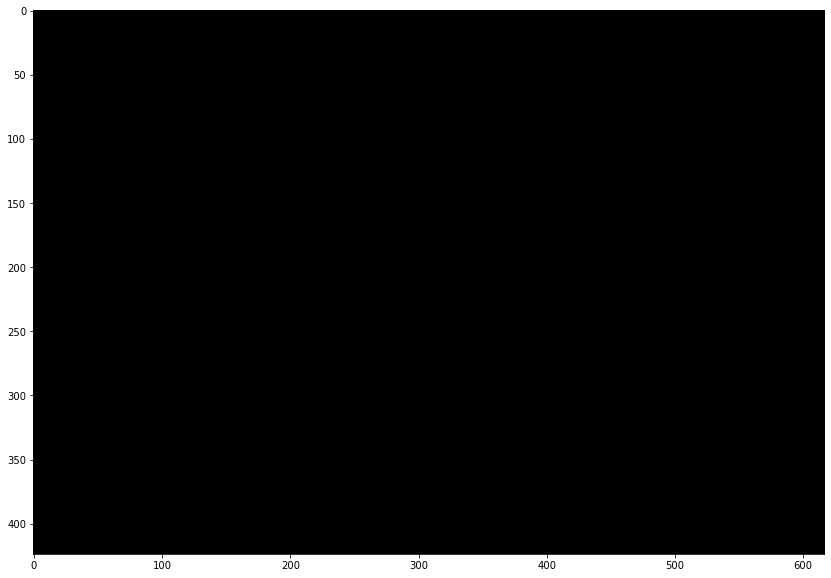

In [26]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread

img = imread('images/mermaid.png')


steps = 4
pyramid_image = np.zeros((img.shape[0] + (2 ** steps), img.shape[1] + (2 ** steps)))
# YOUR CODE HERE

plt.figure(figsize=(15,10))
plt.gray()
plt.imshow(pyramid_image)
plt.show()

## Assignment 3: Texture Segmentation [5 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

Texture can etither be defined by structural, stochastic or spectral features of an image. 

Structural: Elements/ areas in an image

Stochastic: Characteristics of gray value / color distribution

Spectral: Characteristic frequency properties

A standard definition is very hard to define, because of the plenty different approaches which exist.

It will be difficult to define good algorithms which are able to detect segments with the same texture properties.   

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

The co-occurence matrix is a 2-dimensional histogram based on pairs of pixels. These pairs consist of pixels with a specified distance d on a line with a specified angle α to the x-axis. Thus it represents the correlation between pixels.


**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

In [ ]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio 

img = imageio.imread('images/mermaid.png')#, mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    
    Args:
        img (nndarray): Input image.
        x (uint): X-coordinate.
        y (uint): Y-coordinate.
        size (uint): Size of the patch.
        
    Returns:
        result: The extracted patch.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    matrix = np.empty((256, 256))
    # YOUR CODE HERE
    return matrix


plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(8, 8))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    # For visualization one may apply some extra me, e.g., logarithmization or binarization
    plt.subplot(len(patches),3,i+2); plt.imshow(np.log(1 + cooccurrence2(p, 0, 1)), interpolation='none')
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence2(p,1,0)>0, interpolation='none')
    i += 3
plt.show()

## Assignment 4: Region merging [5 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

img = imageio.imread('./images/segments.png', pilmode='L')
# Choosing a large image region lengthens computation time
img = img[64:128,64:128]

# compute the `label` array by implementing "region merging"
# YOUR CODE HERE

plt.figure(figsize=(12, 12))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label, cmap='prism')
plt.show()


warnings.filterwarnings('ignore')

## Bonus: Painting with a webcam using color detection [0 points]


### Testing your webcam: Images
From now on we will try to make the exercises a bit more interactive and use live feed from your webcam. Unfortunately, using the webcam may not always work out of box (depending on your hardware/os configuration). So first make sure that you can grab an image from the webcam.

1. Use the `imageio` library as presented in the tutorial sessions. You will probably need to install `ffmpeg` packages as shown in the tutorial code.
1. Use the `cv2` library (opencv will use `gstreamer`). You will probably need to install then `opencv` package.

Hint: Sometimes it helps to restart the kernel.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set this flag to either use "imageio" or "cv2"
use_imageio = True
if use_imageio:
    # use imageio for accessing the webcam (requires ffmpeg to be installed on your computer)
    import imageio
    try:
        reader = imageio.get_reader('<video0>')
        img = reader.get_next_data()
        ok = True
        reader.close()
    except:
        ok = False
else:
    # use opencv for accessing the webcam
    import cv2
    camera = cv2.VideoCapture(0)
    ok, img = camera.read()
    camera.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if ok:
    plt.imshow(img)
    plt.show()
else:
    print("Accessing your webcam failed.")

### Testing your webcam: Video
You can now test your webcam with video. You can either select the methods presented in the tutorial session, namely `imageio` and `visvis`, or use `cvloop`. We recommend using the first method.

**imageio and visvis**


To test these modules run the following code

In [ ]:
import imageio
import visvis as vv
import time 
import numpy as np

reader = imageio.get_reader('<video0>')

img = reader.get_next_data()
res = np.zeros_like(img)

fig = vv.figure() 
a1 = vv.subplot(121)
im_v = vv.imshow(img, clim=(0, 255))
a1 = vv.subplot(122)
res_v = vv.imshow(res, clim=(0, 255))

for im in reader:
    vv.processEvents()     
    im_v.SetData(im)
    res_v.SetData(255 - im)

**cvloop**

Atlernatively you can use `cvloop`. To install `cvloop` first activate your cv environment and then run the follwing cell. We recommend using

In [ ]:
!pip install cvloop

Check that it works by executing the cell below:

In [ ]:
from cvloop import cvloop
cvl = cvloop(function=lambda frame: 255 - frame, side_by_side=True)

### a)
In this task we will track a small colored object (like the cap of a pen) in front of a neutral background of a different color. We will use the location of the object to paint on a virtual canvas. For that you have to implement the following tasks in the `draw_func` function:

* Convert the image `img` given to the `draw_func` into HSV color space. 
* Measure the color of your object. You may return the converted image and interactively measure the color with your mouse. Define your measured hue value in a constant
* Discard all channel except the hue channel. 
* Find the location with the most similar hue to the measured hue of your object.
* Paint a marker, for example a circle, at this position in `img_draw`.


In [ ]:
%matplotlib inline

import imageio
import visvis as vv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.color import rgb2hsv
from skimage.draw import disk

# Adapt this hue value to the hue of your object
hue = .4

# A global canvas to draw on
canvas = np.zeros((480,640,3), np.uint8) 

# radius and color of the brush
radius = 5
color = (255,255,255)

# saturation threshold for object
thresh = .2

def draw_func(img):
    """
    Draw a circle on img_draw at the detected object location.
    
    Args:
        img          the RGB input image (uint8)

    Returns:
        img_draw     img with circle drawn at postion of object
    """
    global canvas, hue, radius, color
    
    # YOUR CODE HERE
    
    
    return canvas



# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 1))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb = mpl.colorbar.ColorbarBase(ax, cmap=mpl.cm.hsv, orientation='horizontal',
                               norm=mpl.colors.Normalize(vmin=0, vmax=1))
cb.set_ticks([hue])
cb.set_label('the hue value')
plt.show()

In [ ]:
# First test your function with single image. You may either grab an image from your webcam (as described above),
# or choose an arbitrary image from wherever you like

%matplotlib inline
import matplotlib.pyplot as plt

draw_func(img)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(canvas)
plt.show()

In [ ]:
# Now run your function with imageio and visvis or alternatively with cvloop

import imageio
import visvis as vv
import numpy as np


reader = imageio.get_reader('<video0>')

img = reader.get_next_data()
res = np.zeros_like(img)

fig = vv.figure() 
a1 = vv.subplot(121)
im_v = vv.imshow(img, clim=(0, 255))
a1 = vv.subplot(122)
res_v = vv.imshow(res, clim=(0, 255))

for im in reader:
    # mirror the image to make drawing easier
    im = im[:,::-1,:]
    vv.processEvents()     
    im_v.SetData(im)
    res_v.SetData(draw_func(im))

In [ ]:

%matplotlib notebook
from cvloop import cvloop

# Now use cvloop to run the algorithm live on webcam data     
cvl = cvloop(function=draw_func, side_by_side=True)